# AI for Earth System Science Hackathon 2020
# GECKO-A Emulation
David John Gagne, Siyuan Wang, Charlie Becker, Keely Lawrence, Alma Hodzic, Natasha Flyer

## Introduction
Natural and anthropogenic sources emit a large number of volatile organic compounds (VOCs). These compounds greatly affect the “self-cleaning capacity” of the atmosphere. These compounds can also undergo complicated chemical and physical processes in the atmosphere, forming organic aerosols. Organic aerosols have significant direct (absorbing/scattering) and indirect (affect cloud formation/properties) radiation effect.

In order to understand the broad impacts of VOCs on air quality and climate, we need to understand their sources and fates in the atmosphere. Many of these compounds can be directly emitted, or be produced from other compounds; in the meantime, they can undergo a variety of chemical reactions in the atmosphere. The chemical mechanism of these VOCs in the atmosphere can be very highly complicated, especially involving the formation of organic aerosols.

Most air quality models or chemistry-climate models are equipped with chemical mechanisms consisting of hundreds-thousands of chemical reactions. It is often found that such simplified chemical mechanisms are incapable to describe the complicity in the atmosphere. A widely used “near-explicit” chemical mechanism (Master Chemical Mechanism) consists of tens of thousands of chemical reactions, which still cannot capture the behavior and characteristics of the formation of organic aerosols. Such “near-explicit” mechanism is too computationally demanding for most air quality models or chemistry-climate models already.

NCAR (USA) and Centre National de la Recherche Scientifique (CNRS, France) jointly developed a hyper-explicit chemical mechanism: Generator of Explicit Chemistry and Kinetics of Organics in the Atmosphere (GECKO-A). GECKO-A can generate chemical mechanisms based on how the molecules/bonds/atoms interact with each other. Chemical mechanisms generated by GECKO-A usually include millions to tens of millions of reactions. Due to the remarkable computational cost, no air quality models or chemistry-climate models can afford to run with GECKO-A in the foreseeable future. There is a growing interest in the community to implement such complicated mechanisms into air quality models or chemistry-climate models, to study the broader impacts on air quality, human health, and the climate system.

Machine‐learning and artificial intelligence have proven to be a valuable tool in atmospheric science. Recent years have seen quite a few inspiring applications in developing machine-learning emulators using explicit/process-level models and implementing the trained emulators into large-scale models. Such explicit/process-level models are otherwise too expensive for large-scale models.

The goal of this project is to train the machine-learning emulator using the “library” generated by the hyper-explicit chemical mechanism, GECKO-A. 


## Software Requirements
This notebook requires Python >= 3.7. The following libraries are required:
* numpy
* scipy
* matplotlib
* xarray
* pandas
* scikit-learn
* tensorflow >= 2.1
* netcdf4
* tqdm

In [1]:
! pip install numpy scipy matplotlib xarray pandas netcdf4 tqdm tensorflow scikit-learn

In [2]:
# Include imports here
import numpy as np
import pandas as pd
import xarray as xr
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

## Data
 **Data generation procedure**: The machine-learning training dataset in this project (or library) is generated by the hyper-explicit chemical mechanism, GECKO-A. This library consists of results from thousands of GECKO-A simulations under vastly different conditions. More information about GECKO-A can be found [here](https://www2.acom.ucar.edu/modeling/gecko). Each model run lasts 5 simulation days.
 
 ### Potential Input Variables
* Temperature (K): The temperature at which the GECKO-A experiments were conducted. Temperature will affect the reaction rates of many reactions. It also affects the partitioning of a given compound between the gas-phase and particle-phase.
* Solar zenith angle (degree): The solar zenith angle at which the GECKO-A experiments were conducted. This will affect the photolysis reactions. 
* Pre-existing aerosols (micrograms per cubic meter): Depending on the environmental conditions (e.g., temperature) and the vapor pressure, a compound can deposit onto (pre-existing) aerosols or evaporate from the aerosols. 
* NOx (ppb): concentration of nitrogen oxides. These are important compounds in the atmosphere, affecting the chemical mechanisms of many volatile organic compounds.
* O3 (ppb): concentration of ozone. It’s another important compounds in the atmosphere, affecting the chemical mechanisms of many VOCs.
* OH (10^6 molecules per cubic centimeter): concentration of hydroxyl radicals (OH). It’s one of the most important oxidants in the atmosphere, largely driving the oxidation of many VOCs.

### Output Variables
* Precursor (micrograms per cubic meter): time series of the VOC precursor. We call it “precursor” because it’ll undergo chemical reactions and produce other compounds.
* Gas (micrograms per cubic meter): mass concentration of products in the gas-phase.
* Aerosol (micrograms per cubic meter): mass concentration of products in the aerosol-phase.
(guess we can ignore other outputs and ask the kids to work on the total masses only)

### Training, validation, and testing sets
This training dataset/library consists of 2000 GECKO experiments, i.e., 2000 input files. Each input file includes the GECKO-A modeling results for 5 consecutive days.


In [3]:
import s3fs
import pandas as pd
import pyarrow
import re
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from os.path import join, exists
from matplotlib.colors import LogNorm
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from sklearn.model_selection import GroupKFold
from tensorflow.keras.optimizers import Adam
%matplotlib inline

In [4]:
def fetch_data(f):
    """
    Load data directly from Amazon S3 storage 
    Args:
        f = file name (parquet format) from Amazon S3 Bucket
    Returns:
        df: Pandas dataframe
    """
    obj = fs.open(f)
    df = pd.read_parquet(obj)
    return df

def prepare_data(data, input_columns, output_columns):
    
    x_data = data[input_columns].iloc[:-1, :]
    y_data = data[output_columns].iloc[1:, :]
    
    return x_data, y_data

def get_exp_nums(data):
    """ Return unique experiments from dataset """
    ids = data['id'].unique()
    exps = [int(x[3:]) for x in ids]
    return exps

def calc_pdf_hist(x, x_bins):
    return np.histogram(x, x_bins, density=True)[0]

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def hellinger(x, pdf_p, pdf_q):
    pdf_distances = (np.sqrt(pdf_p) - np.sqrt(pdf_q)) ** 2
    return np.trapz(pdf_distances, x) / 2

def hellinger_distance(y_true, y_pred, bins=50):
    bin_points = np.linspace(np.minimum(y_true.min(), y_pred.min()),
                       np.maximum(y_true.max(), y_pred.max()),
                       bins)
    bin_centers = 0.5 * (bin_points[:-1] + bin_points[1:])
    y_true_pdf = calc_pdf_hist(y_true, bin_points)
    y_pred_pdf = calc_pdf_hist(y_pred, bin_points)
    return hellinger(bin_centers, y_true_pdf, y_pred_pdf)

def r2_corr(y_true, y_pred):
    return np.corrcoef(y_true, y_pred)[0, 1] ** 2

def dense_neural_net(num_layers=2, num_neurons=100, activation="relu", learning_rate=0.0001,
                     num_input_columns=9, num_output_columns=3):
    input_layer = Input(num_input_columns)
    n_net = input_layer
    for l in range(num_layers):
        n_net= Dense(num_neurons, activation=activation)(n_net)
    out = Dense(num_output_columns)(n_net)
    mod = Model(input_layer, out)
    mod.compile(Adam(learning_rate=learning_rate), "mse")
    return mod

def get_starting_conds(data, input_vars, exp_num, starting_ts=0):
    """
    Get starting conditions for box/forward running emulator.
    Args:
        input_vars: List of varibles to subset for input
        ouput_vars: List of varibles to subset for ouput
        exp_num: Which experiment the box model will be run on
        starting_ts: Starting timestep to use for box emulator
    Returns:
        ts_data: Timestep data to be used as initial input to box emulator (np.array)
    """
    exp_data = data[data['id'] == exp_num]
    
    if exp_data.shape[0] == 0:
        raise ValueError('That expiriment number does not exist in this dataset.')
    
    ts_data = exp_data.iloc[starting_ts:starting_ts+1, 1:-1].values

    return ts_data


def box_emulator(neural_network, starting_conds, input_scaler, output_scaler, num_timesteps=1440):
    
    mod = neural_network
    scaled_input = input_scaler.transform(starting_conds)
    static_input = scaled_input[:,-6:]

    for i in range(num_timesteps):

        if i == 0:

            pred = mod.predict(scaled_input)
            new_input = np.concatenate([pred,static_input], axis=1)
            pred_array = pred

        else:

            pred = mod.predict(new_input)
            new_input = np.concatenate([pred,static_input], axis=1)
            pred_array = np.concatenate([pred_array, pred], axis=0)

    results = pd.DataFrame(output_scaler.inverse_transform(pred_array))
    return results

def run_emulator_ensemble(data, mod, num_expiriments, input_vars, input_scaler, 
                          output_scaler, run_length=1440):
    """ ...."""
    exps = random.sample(list(val['id'].unique()), num_expiriments)
    df  = pd.DataFrame(columns = data.columns[[1,2,3, -1]])
    
    for i in range(num_expiriments):
        
        data_sub = data[data['id'] == exps[i]]
        init_conds = get_starting_conds(data, input_vars, exps[i])
        preds = box_emulator(mod, init_conds, input_scaler, output_scaler, run_length)
        preds['id'] = exps[i]
        preds.columns = df.columns
        df = df.append(preds, ignore_index=True)

    return df

def evaluate_box_mod(model_results, true_output):
    
    #model_results = model_results.sort_values('id')
    exps_run = model_results['id'].unique()
    true_subset = true_output.loc[true_output['id'].isin(exps_run)]
    variable = true_output.columns
    
    print('RMSE: Precursor: {:.3f}, Gas: {:.3f}, Aerosols: {:.3f}'.format(
        rmse(true_subset.iloc[:,0], model_results.iloc[:,0]),
        rmse(true_subset.iloc[:,1], model_results.iloc[:,1]),
        rmse(true_subset.iloc[:,2], model_results.iloc[:,2])))
    print('R2: Precursor: {:.3f}, Gas: {:.3f}, Aerosols: {:.3f}'.format(
        r2_corr(true_subset.iloc[:,0], model_results.iloc[:,0]),
        r2_corr(true_subset.iloc[:,1], model_results.iloc[:,1]),
        r2_corr(true_subset.iloc[:,2], model_results.iloc[:,2])))
    print('Hellenger Distance: Precursor: {:.3f}, Gas: {:.3f}, Aerosols: {:.3f}'.format(
        hellinger_distance(true_subset.iloc[:,0], model_results.iloc[:,0]),
        hellinger_distance(true_subset.iloc[:,1], model_results.iloc[:,1]),
        hellinger_distance(true_subset.iloc[:,2], model_results.iloc[:,2])))
    
    return true_subset 

In [5]:
fs = s3fs.S3FileSystem(anon=True)
gecko_files = fs.ls("ncar-aiml-data-commons/gecko/")[1:]
test, train, val = map(fetch_data, gecko_files)

In [6]:
train.shape, test.shape, val.shape, 

((2016000, 11), (288000, 11), (288000, 11))

In [7]:
train.head()

,Time [s],Precursor [ug/m3],Gas [ug/m3],Aerosol [ug_m3],temperature (K),solar zenith angle (degree),pre-existing aerosols (ug/m3),o3 (ppb),nox (ppb),oh (10^6 molec/cm3),id
0,1.000000,0.069675,0.000000,0.000000,264.135037,78.052738,0.022782,38.768707,0.206029,7.360145,Exp1666
1,301.207794,0.067673,0.002783,0.000001,264.135037,78.052738,0.022782,38.768707,0.206029,7.360145,Exp1666
2,601.415588,0.065728,0.005749,0.000004,264.135037,78.052738,0.022782,38.768707,0.206029,7.360145,Exp1666
3,901.623352,0.063838,0.008627,0.000008,264.135037,78.052738,0.022782,38.768707,0.206029,7.360145,Exp1666
4,1201.831177,0.062003,0.011420,0.000013,264.135037,78.052738,0.022782,38.768707,0.206029,7.360145,Exp1666


In [8]:
input_vars, output_vars = train.columns[1:-1], train.columns[[1,2,3,-1]]
train_in, train_out = prepare_data(train, input_vars, output_vars)
val_in, val_out = prepare_data(val, input_vars, output_vars)

input_scaler = MinMaxScaler()
output_scaler = MinMaxScaler()

scaled_train_in = input_scaler.fit_transform(train_in)
scaled_train_out = output_scaler.fit_transform(train_out.iloc[:,:-1])
scaled_val_in = input_scaler.transform(val_in)
scaled_val_out = output_scaler.transform(val_out.iloc[:,:-1])

In [9]:
%%time
mod = dense_neural_net()
history = mod.fit(scaled_train_in, scaled_train_out, validation_data=(scaled_val_in, scaled_val_out), 
                  batch_size=1024, epochs=10, verbose=1)

Epoch 1/10
1969/1969 [==============================] - 6s 3ms/step - loss: 0.0042 - val_loss: 3.7150e-04
Epoch 2/10
1969/1969 [==============================] - 6s 3ms/step - loss: 3.3834e-04 - val_loss: 3.1452e-04
Epoch 3/10
1969/1969 [==============================] - 6s 3ms/step - loss: 3.0579e-04 - val_loss: 2.9683e-04
Epoch 4/10
1969/1969 [==============================] - 6s 3ms/step - loss: 2.9386e-04 - val_loss: 2.8946e-04
Epoch 5/10
1969/1969 [==============================] - 6s 3ms/step - loss: 2.8839e-04 - val_loss: 2.8163e-04
Epoch 6/10
1969/1969 [==============================] - 6s 3ms/step - loss: 2.8548e-04 - val_loss: 2.7918e-04
Epoch 7/10
1969/1969 [==============================] - 6s 3ms/step - loss: 2.8412e-04 - val_loss: 2.7732e-04
Epoch 8/10
1969/1969 [==============================] - 6s 3ms/step - loss: 2.8314e-04 - val_loss: 2.7778e-04
Epoch 9/10
1969/1969 [==============================] - 6s 3ms/step - loss: 2.8250e-04 - val_loss: 2.7791e-04
Epoch 10/10
19

In [11]:
%%time
results_df = run_emulator_ensemble(val, mod, 3, input_vars, input_scaler, output_scaler)

CPU times: user 2min 13s, sys: 1.9 s, total: 2min 15s
Wall time: 2min 12s


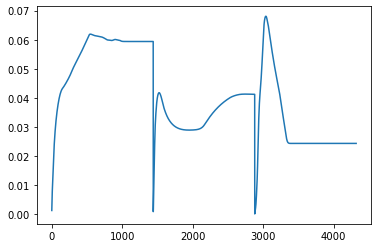

In [12]:
results_df.iloc[:,1].plot()

## Hackathon Challenges

### Monday
* Load the data
* Create an exploratory visualization of the data
* Test two different transformation and scaling methods
* Test one dimensionality reduction method
* Train a linear model
* Train a decision tree ensemble method of your choice

In [ ]:
# Monday's code goes here


### Tuesday
* Train a densely connected neural network
* Train a convolutional or recurrent neural network (depends on problem)
* Experiment with different architectures

In [ ]:
# Tuesday's code goes here


### Wednesday
* Calculate three relevant evaluation metrics for each ML solution and baseline
* Refine machine learning approaches and test additional hyperparameter settings

In [ ]:
#Wednesday's code goes here


### Thursday 
* Evaluate two interpretation methods for your machine learning solution
* Compare interpretation of baseline with your approach
* Submit best results on project to leaderboard
* Prepare 2 Google Slides on team's approach and submit them 

In [5]:
#Thursday's code goes here


## Ultimate Submission Code
Please insert your full data processing and machine learning pipeline code in the cell below.